## Packages

In [210]:
import pandas as pd, numpy as np, seaborn as sns
import glob
import datetime
import matplotlib.pyplot as plt
import math

## Input all files

In [2]:
path = r'./player_stats_table' # use your path
files_path = glob.glob(path + "/*.csv")

mutiple_files = [pd.read_csv(file, index_col = None) for file in files_path]
df = pd.concat(mutiple_files, axis  = 0, ignore_index=True)
df.drop(df.columns[0], axis = 1, inplace = True)
df.head(5)

,Date,Game_Index,Home_Away,Team,Players,MP,FG,FGA,FG%,3P,...,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg
0,2018-10-16,1,Home,BOS,Al Horford,29:57,4.0,7.0,0.571,0.0,...,0.0,13.1,6.3,9.0,0.0,10.5,28.7,14.3,90.0,80.0
1,2018-10-16,1,Home,BOS,Kyrie Irving,29:00,2.0,14.0,0.143,1.0,...,0.0,13.5,6.5,29.9,0.0,0.0,16.8,25.3,63.0,89.0
2,2018-10-16,1,Home,BOS,Jayson Tatum,28:56,9.0,17.0,0.529,1.0,...,6.3,23.7,14.6,18.4,1.6,0.0,5.0,28.6,125.0,83.0
3,2018-10-16,1,Home,BOS,Jaylen Brown,28:23,5.0,13.0,0.385,1.0,...,9.6,6.9,8.3,10.1,0.0,0.0,12.6,22.9,91.0,89.0
4,2018-10-16,1,Home,BOS,Gordon Hayward,24:37,4.0,12.0,0.333,1.0,...,7.4,11.9,9.6,0.0,7.5,0.0,0.0,21.4,90.0,74.0


In [ ]:
df.shape

### Teams Played by Date

> The following information is used to scrape line-up data.

In [ ]:
team_played_date = df.loc[:, ["Date", "Game_Index", "Team"]].drop_duplicates()
team_played_date.reset_index(drop = True, inplace = True)
date_str = team_played_date["Date"].map(str)

def getGameYear(date_col):
    gameYear = []
    for day in date_str:
        if int(day.split("-")[1]) >= 9:
            gameYear.append(day.split("-")[0][-2:])
        else:
            gameYear.append(str(int(day.split("-")[0][-2:]) - 1))
    return gameYear

team_played_date["GameYear"] = getGameYear(date_str)

In [ ]:
#team_played_date.to_csv("Team_Played_Date.csv", index = False)

## Cleaning

### Is there NA value in the raw dataset?

In [125]:
# Missing Value
col_has_missing = df.isnull().apply(sum, axis = 0) > 0
missing_value = pd.DataFrame(df.isnull().apply(sum, axis = 0)[col_has_missing]).transpose()
missing_value

,FG%,3P%,FT%,+/-,TS%,eFG%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg
0,16229,122491,135441,36,14103,16229,16229,16229,59,59,59,63,59,59,11211,59,59,56


### Why is there a missing data?

> By checking out the number of missing data in each column, it seems there are some patterns among several columns. I guess the data is missing by certain reasons. So, let's get a closer look.

> According to the amount of missing data, I separate the columns into a few groups. Most of them are the percentage information of another independent variable.

1. 16229: FG%, eFG%, 3PAr, FTr

2. 12491: 3P%

3. 135441: FT%

4. 14103: TS%

5. 11211: TOV%

6. 63: AST%

7. 59: ORB%, DRB%, TRB%, STL%, BLK%, USG%, ORtg

8. 56: DRtg

9. 36: +/-,  

> **Conclusion 1:** <br> 1. Players who did not play the game would not have a record. <br><br> 2. Taking TOV% as an example, the reason why TOV% is missing is resulted by the zero number of TOV. <br><br> 3. Plus-Minus a.k.a. +/-, simply keeps track of the net changes in score when a given player is either on or off the court. It looks like when a player only plays less than one minute, it would be NA. However, since the player did not have much contribution, I will just take it as a zero. <br><br> **Conclusion 2:** <br> When counting the weighted average, I will ignore the NA value.

#### who has all the missing value?

In [134]:
#sum(df.isnull().apply(sum, axis = 1) == len(missing_value.columns)) #19
df[df.isnull().apply(sum, axis = 1) == len(missing_value.columns)].head(5)

,Date,Game_Index,Home_Away,Team,Players,MP,SP,FG,FGA,FG%,...,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg
5789,2018-11-23,5,Home,DET,José Calderón,0:00,0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80234,2009-05-11,2,Away,DEN,Renaldo Balkman,0:00,0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85899,2012-12-02,1,Away,ORL,Gustavo Ayón,0:00,0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115996,2007-12-20,2,Home,DEN,Bobby Jones,0:00,0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140366,2013-12-02,3,Away,ATL,Pero Antić,0:00,0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### What about players who have "MP" more than 0:00

In [151]:
seconds_true_false = df["MP"].map(lambda x: int(x.split(":")[0]) * 60 + int(x.split(":")[1])) > 0
df_played = df[seconds_true_false]
col_played_missing = df_played.isnull().apply(sum, axis = 0) > 0
played_missing_value = pd.DataFrame(df_played.isnull().apply(sum, axis = 0)[col_played_missing]).transpose()
played_missing_value

,FG%,3P%,FT%,+/-,TS%,eFG%,3PAr,FTr,AST%,TOV%
0,16170,122432,135386,14,14048,16170,16170,16170,4,11156


#### Percentage %

Including FG%, 3P%, FT%, TS%, eFG%, AST%, TOV%

In [159]:
percentage_missing = played_missing_value.drop(["+/-"], axis = 1).columns
df_played[df_played.loc[:, list(percentage_missing)].isnull().apply(sum, axis = 1) > 0].head(5)

,Date,Game_Index,Home_Away,Team,Players,MP,SP,FG,FGA,FG%,...,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg
5,2018-10-16,1,Home,BOS,Terry Rozier,26:31,1591,5.0,10.0,0.500,...,0.0,29.6,14.2,5.5,0.0,3.0,9.1,17.0,102.0,84.0
7,2018-10-16,1,Home,BOS,Marcus Morris,20:30,1230,7.0,12.0,0.583,...,8.8,38.2,23.0,0.0,4.5,0.0,7.7,26.0,122.0,74.0
8,2018-10-16,1,Home,BOS,Aron Baynes,19:14,1154,3.0,7.0,0.429,...,14.1,5.1,9.8,21.7,0.0,0.0,12.5,17.0,124.0,89.0
9,2018-10-16,1,Home,BOS,Daniel Theis,4:08,248,0.0,0.0,NaN,...,0.0,23.7,11.4,0.0,0.0,0.0,NaN,0.0,0.0,86.0
10,2018-10-16,1,Home,BOS,Semi Ojeleye,1:27,87,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,91.0


#### +/-

In [175]:
# plus and minus is missing
df_played[df_played["+/-"].isnull()].iloc[:10, :30]

,Date,Game_Index,Home_Away,Team,Players,MP,SP,FG,FGA,FG%,...,STL,BLK,TOV,PF,PTS,+/-,TS%,eFG%,3PAr,FTr
207,2018-10-17,8,Home,PHO,Mikal Bridges,0:11,11,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1820,2018-10-28,2,Home,DAL,Ryan Broekhoff,0:21,21,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
21642,2019-03-17,4,Home,MIA,Duncan Robinson,0:11,11,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
65917,2009-01-14,8,Home,OKC,Chucky Atkins,0:50,50,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
141148,2013-12-07,7,Away,DAL,Wayne Ellington,0:17,17,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
159622,2014-04-11,10,Away,WAS,Garrett Temple,0:01,1,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
160976,2014-04-25,3,Home,WAS,Al Harrington,0:07,7,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
162304,2014-05-31,1,Home,OKC,Thabo Sefolosha,0:05,5,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
196107,2011-01-09,7,Away,SAC,Darnell Jackson,0:01,1,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
214174,2014-11-12,8,Away,BRK,Cory Jefferson,0:06,6,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [177]:
df_played[df_played["+/-"].isnull()]["SP"]

207       11
1820      21
21642     11
65917     50
141148    17
159622     1
160976     7
162304     5
196107     1
214174     6
227183    44
227194    44
319714     3
321937    12
Name: SP, dtype: int64

In [176]:
# plus and minus is zero
df_played[df_played["+/-"] == 0].iloc[:10, :30]

,Date,Game_Index,Home_Away,Team,Players,MP,SP,FG,FGA,FG%,...,STL,BLK,TOV,PF,PTS,+/-,TS%,eFG%,3PAr,FTr
34,2018-10-16,2,Home,GSW,Jonas Jerebko,6:10,370,0.0,0.0,NaN,...,0.0,0.0,1.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN
39,2018-10-16,2,Away,OKC,Terrance Ferguson,26:31,1591,0.0,2.0,0.000,...,0.0,0.0,1.0,3.0,0.0,0.0,0.000,0.000,1.000,0.000
74,2018-10-17,2,Home,DET,Glenn Robinson,20:04,1204,2.0,3.0,0.667,...,1.0,1.0,1.0,0.0,4.0,0.0,0.667,0.667,0.333,0.000
76,2018-10-17,2,Home,DET,Zach Lofton,3:45,225,0.0,1.0,0.000,...,1.0,0.0,1.0,0.0,0.0,0.0,0.000,0.000,1.000,0.000
121,2018-10-17,4,Home,IND,T.J. Leaf,0:58,58,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
138,2018-10-17,5,Home,LAC,Shai Gilgeous-Alexander,28:12,1692,5.0,6.0,0.833,...,1.0,1.0,3.0,1.0,11.0,0.0,0.854,0.833,0.000,0.167
152,2018-10-17,5,Away,DEN,Mason Plumlee,13:22,802,1.0,3.0,0.333,...,0.0,3.0,1.0,5.0,2.0,0.0,0.258,0.333,0.000,0.667
168,2018-10-17,6,Away,ATL,Kent Bazemore,30:16,1816,6.0,12.0,0.500,...,2.0,1.0,2.0,3.0,14.0,0.0,0.583,0.583,0.500,0.000
215,2018-10-17,8,Away,DAL,Dwight Powell,17:29,1049,6.0,8.0,0.750,...,1.0,1.0,0.0,1.0,16.0,0.0,0.752,0.750,0.125,0.750
250,2018-10-17,10,Away,MIN,Andrew Wiggins,37:27,2247,8.0,18.0,0.444,...,1.0,0.0,2.0,3.0,20.0,0.0,0.530,0.500,0.333,0.111


## Win or Loss

> Extracting the outcome of the game and returning 1 as the home team won

In [87]:
def SumPoints(group):
    return group["PTS"].sum()

# do group by
df_drop = df.drop(["Players", "MP", "SP"], axis = 1)
df_drop_grouped = df_drop.groupby(["Date", "Game_Index", "Team", "Home_Away"])
# Get the score
table_grouped = df_drop_grouped.apply(SumPoints)
win_loss_df = pd.DataFrame(table_grouped, columns = ["HomeWin"]).reset_index()

# count win or loss as 1 and 0
win_loss_df_sorted = win_loss_df.sort_values(by = ["Date", "Game_Index", "Home_Away"])
win_loss_df_sorted = win_loss_df_sorted.groupby(["Date", "Game_Index"]).apply(lambda x: x.iloc[0, 4] < x.iloc[1, 4])
win_loss_df_sorted = pd.DataFrame(win_loss_df_sorted, columns = ["HomeWin"]).reset_index()

In [88]:
win_loss_df_sorted.head(10)

,Date,Game_Index,HomeWin
0,2007-10-30,1,False
1,2007-10-30,2,False
2,2007-10-30,3,True
3,2007-10-31,1,False
4,2007-10-31,2,True
5,2007-10-31,3,True
6,2007-10-31,4,False
7,2007-10-31,5,True
8,2007-10-31,6,True
9,2007-10-31,7,True


## Team Data Transformation

> Implement weighted average transformation from the player-level data to the team-level data

In [3]:
# Minute Played to Second Played
df.insert(6,
          "SP",
          df["MP"].map(lambda x: int(x.split(":")[0]) * 60 + int(x.split(":")[1])))

In [6]:
def team_table_transformed(df):
    df_drop = df.drop(["Players", "MP"], axis = 1)
    df_drop_grouped = df_drop.groupby(["Date", "Game_Index", "Team", "Home_Away"])

    def weightedavg(group, col):
        d = group[col]
        w = group["SP"]
        return (d * w).sum() / w.sum() #will ignore missing value

    table_transformed = []
    for col in list(df_drop.columns[5:]):
        table_transformed.append(df_drop_grouped.apply(lambda x: weightedavg(x, col)))
    new_df = pd.concat(table_transformed, axis = 1)
    new_df.columns = list(df_drop.columns[5:])
    
    return new_df

In [7]:
new_df = team_table_transformed(df).reset_index()

## Delete Playoff Game

> We only analyze the regular season of the game.

In [94]:
# Regular Season or not
def getRegularSeason(table, date_col):
    regularseason = []
    for gameday in table[date_col]:
        d = datetime.date(int(gameday.split("-")[0]),
                          int(gameday.split("-")[1]),
                          int(gameday.split("-")[2]))
        if datetime.date(2006,10,31) <= d <= datetime.date(2007,4,18):
            regularseason.append(1)
        elif datetime.date(2007,10,30) <= d <= datetime.date(2008,4,16):
            regularseason.append(1)
        elif datetime.date(2008,10,28) <= d <= datetime.date(2009,4,16):
            regularseason.append(1)
        elif datetime.date(2009,10,27) <= d <= datetime.date(2010,4,14):
            regularseason.append(1)
        elif datetime.date(2010,10,26) <= d <= datetime.date(2011,4,13):
            regularseason.append(1)
        elif datetime.date(2011,12,25) <= d <= datetime.date(2012,4,26):
            regularseason.append(1)        
        elif datetime.date(2012,10,30) <= d <= datetime.date(2013,4,17):
            regularseason.append(1)    
        elif datetime.date(2013,10,29) <= d <= datetime.date(2014,4,16):
            regularseason.append(1)  
        elif datetime.date(2014,10,28) <= d <= datetime.date(2015,4,15):
            regularseason.append(1)
        elif datetime.date(2015,10,27) <= d <= datetime.date(2016,4,13):
            regularseason.append(1)   
        elif datetime.date(2016,10,25) <= d <= datetime.date(2017,4,12):
            regularseason.append(1)
        elif datetime.date(2017,10,17) <= d <= datetime.date(2018,4,11):
            regularseason.append(1)
        elif datetime.date(2018,10,16) <= d <= datetime.date(2019,4,10):
            regularseason.append(1)
        else:
            regularseason.append(0)

    table["RegularSeason"] = regularseason

    return table[table["RegularSeason"] == 1]

new_df = getRegularSeason(new_df, "Date")
new_df.drop("RegularSeason", axis = 1, inplace = True)
new_df.head()

,Date,Game_Index,Team,Team_id,Home_Away,FG,FGA,FG%,3P,3PA,...,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg
0,2007-10-30,1,GSW,1610612744,Home,3.826875,8.841667,0.423291,0.574375,2.469444,...,2.972972,13.054153,7.961743,15.646465,1.525562,2.267069,18.271097,20.005417,91.476319,111.440000
1,2007-10-30,1,UTA,1610612762,Away,5.307222,10.969792,0.383974,0.550347,1.023472,...,6.945368,17.022208,12.038257,14.562708,1.704708,2.582854,15.920604,19.993611,107.595486,91.194236
2,2007-10-30,2,HOU,1610612745,Away,4.926042,10.376667,0.451923,0.755486,2.847222,...,6.316465,15.416035,11.405576,16.642792,2.156701,1.464347,17.795868,19.987507,107.296944,99.171181
3,2007-10-30,2,LAL,1610612747,Home,4.555934,10.394417,0.439086,0.319631,1.181099,...,4.597042,13.690494,8.592445,14.665398,3.440643,1.157996,11.630491,19.987168,95.756197,102.605514
4,2007-10-30,3,POR,1610612757,Away,5.154583,10.013611,0.502520,0.872847,1.758264,...,4.446646,14.545174,9.996299,9.080931,0.225104,1.256007,16.961451,19.979035,105.751528,115.450972


In [ ]:
new_df.shape

### Save the Weighted Average Table

> Because it takes so long to compute

In [9]:
#new_df.to_csv("weighted_average_table/weighted_average_team.csv", index = False)

In [63]:
new_df = pd.read_csv("weighted_average_table/weighted_average_team.csv")
new_df.head()

,Date,Game_Index,Team,Home_Away,FG,FGA,FG%,3P,3PA,3P%,...,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg
0,2007-10-30,1,GSW,Home,3.826875,8.841667,0.423291,0.574375,2.469444,0.145155,...,2.972972,13.054153,7.961743,15.646465,1.525562,2.267069,18.271097,20.005417,91.476319,111.440000
1,2007-10-30,1,UTA,Away,5.307222,10.969792,0.383974,0.550347,1.023472,0.137587,...,6.945368,17.022208,12.038257,14.562708,1.704708,2.582854,15.920604,19.993611,107.595486,91.194236
2,2007-10-30,2,HOU,Away,4.926042,10.376667,0.451923,0.755486,2.847222,0.140722,...,6.316465,15.416035,11.405576,16.642792,2.156701,1.464347,17.795868,19.987507,107.296944,99.171181
3,2007-10-30,2,LAL,Home,4.555934,10.394417,0.439086,0.319631,1.181099,0.106437,...,4.597042,13.690494,8.592445,14.665398,3.440643,1.157996,11.630491,19.987168,95.756197,102.605514
4,2007-10-30,3,POR,Away,5.154583,10.013611,0.502520,0.872847,1.758264,0.312500,...,4.446646,14.545174,9.996299,9.080931,0.225104,1.256007,16.961451,19.979035,105.751528,115.450972


## Add Team ID

> Because some teams used to change the location and the team name, using the team id instead of team name will help me to move the feature information from the t period to the t-1 period

In [67]:
# Team ID
id_dict = {}
with open("Team_id.txt", "r") as file:
    for line in file:
        id_dict[line.split("|")[0]] = line.split("|")[1].strip("\n")

new_df.insert(3, "Team_id", [id_dict[tm] for tm in new_df["Team"]])
#new_df["Team_id"] = [id_dict[tm] for tm in new_df["Team"]]

In [45]:
new_df.head()

,Date,Game_Index,Team,Team_id,Home_Away,FG,FGA,FG%,3P,3PA,...,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,RegularSeason
0,2007-10-30,1,GSW,1610612744,Home,3.826875,8.841667,0.423291,0.574375,2.469444,...,13.054153,7.961743,15.646465,1.525562,2.267069,18.271097,20.005417,91.476319,111.440000,1
1,2007-10-30,1,UTA,1610612762,Away,5.307222,10.969792,0.383974,0.550347,1.023472,...,17.022208,12.038257,14.562708,1.704708,2.582854,15.920604,19.993611,107.595486,91.194236,1
2,2007-10-30,2,HOU,1610612745,Away,4.926042,10.376667,0.451923,0.755486,2.847222,...,15.416035,11.405576,16.642792,2.156701,1.464347,17.795868,19.987507,107.296944,99.171181,1
3,2007-10-30,2,LAL,1610612747,Home,4.555934,10.394417,0.439086,0.319631,1.181099,...,13.690494,8.592445,14.665398,3.440643,1.157996,11.630491,19.987168,95.756197,102.605514,1
4,2007-10-30,3,POR,1610612757,Away,5.154583,10.013611,0.502520,0.872847,1.758264,...,14.545174,9.996299,9.080931,0.225104,1.256007,16.961451,19.979035,105.751528,115.450972,1


## Getting all features at t-1 period

> For every team, I shifted their features back to the the last game. So, the first game in 2007 is removed. Then, I also marked the feature name with "_1"

In [68]:
unique_team_id = list(set(new_df["Team_id"]))
table_t_1 = []
for teamid in unique_team_id:
    one_team_df = new_df[new_df["Team_id"] == teamid].sort_values(by = "Date", ascending = False)
    # without the first row of features
    right = one_team_df.iloc[1:, 5:].reset_index(drop = True)
    # without the last row of game information
    left = one_team_df.iloc[:-1, :5].reset_index(drop = True)
    # merge left and right
    merge_table = pd.concat([left, right], axis = 1)
    table_t_1.append(merge_table)

In [76]:
# New Dataframe
df_t1 = pd.concat(table_t_1, axis = 0)

In [74]:
df_t1[df_t1["Team_id"] == "1610612760"].head()

,Date,Game_Index,Team,Team_id,Home_Away,FG_1,FGA_1,FG%_1,3P_1,3PA_1,...,ORB%_1,DRB%_1,TRB%_1,AST%_1,STL%_1,BLK%_1,TOV%_1,USG%_1,ORtg_1,DRtg_1
0,2019-04-10,7,OKC,1610612760,Away,5.424167,13.562708,0.412397,2.223125,6.062986,...,7.045292,16.177854,11.433896,13.909410,1.049847,1.141181,10.124174,20.006181,116.803264,116.113958
1,2019-04-09,9,OKC,1610612760,Home,6.186181,12.361111,0.590380,1.791181,4.650417,...,6.995083,16.845486,11.787993,14.621125,1.186069,1.295028,12.073090,19.987840,138.973264,124.345139
2,2019-04-07,10,OKC,1610612760,Away,5.846806,12.543750,0.559587,1.471875,3.675000,...,8.586521,18.087319,12.961549,15.699167,1.945354,1.993757,17.819007,19.998535,116.512153,107.405556
3,2019-04-05,9,OKC,1610612760,Home,5.900694,12.879444,0.477356,1.758472,5.644861,...,6.524715,17.837722,11.238736,17.834590,2.903167,3.110771,9.474201,20.002917,114.912222,99.737986
4,2019-04-02,2,OKC,1610612760,Home,5.645139,13.376736,0.346477,1.689375,5.691250,...,5.265535,15.463847,9.699681,13.663125,1.219118,2.796667,5.342493,20.013549,96.887361,109.424236


## Create Home and Away features.

> To do so, I will separate the table into a home team table and a away team table. Then, I will concatenate the two tables by the date and the game index.

In [79]:
home_table = df_t1[df_t1["Home_Away"] == "Home"]
away_table = df_t1[df_t1["Home_Away"] == "Away"]

In [106]:
final_df_t1 = home_table.merge(away_table, on = ["Date", "Game_Index"], suffixes = ("_h", "_a"))

In [ ]:
# Use the following scripts, if I want to add _1 befind every feature name
#new_col = list(new_df.columns[:5]) + [i+"_1" for i in new_df.columns[5:]]
#df_t1.columns = new_col

### Add the game outcome column

> I have compute the outcome in the section 3.

In [107]:
final_df_t1.shape

(14500, 74)

In [108]:
final_df_t1 = win_loss_df_sorted.merge(final_df_t1, how = "right", on = ["Date", "Game_Index"])
final_df_t1.drop(["RegularSeason", "Home_Away_h"], axis = 1, inplace = True)

In [109]:
final_df_t1.head()

,Date,Game_Index,HomeWin,Team_h,Team_id_h,FG_h,FGA_h,FG%_h,3P_h,3PA_h,...,ORB%_a,DRB%_a,TRB%_a,AST%_a,STL%_a,BLK%_a,TOV%_a,USG%_a,ORtg_a,DRtg_a
0,2007-11-01,3,False,UTA,1610612762,5.307222,10.969792,0.383974,0.550347,1.023472,...,6.316465,15.416035,11.405576,16.642792,2.156701,1.464347,17.795868,19.987507,107.296944,99.171181
1,2007-11-02,4,False,CHI,1610612741,5.062138,12.638868,0.400053,1.054654,3.036038,...,7.138956,15.105083,11.079654,14.945004,0.656447,2.602597,13.321290,19.998250,107.244358,116.952156
2,2007-11-02,6,True,IND,1610612754,4.617005,10.916609,0.414678,1.651154,3.363499,...,2.693604,14.892375,9.528479,10.501583,0.895111,1.309208,16.761042,19.995188,85.679444,101.400833
3,2007-11-02,9,False,NJN,1610612751,4.051258,10.070000,0.354623,1.062075,3.032516,...,4.874632,12.863125,8.919222,14.446687,1.758736,1.228354,7.308944,20.012090,122.459236,106.739375
4,2007-11-02,10,True,NOH,1610612740,4.920069,9.308264,0.499835,1.254444,2.410486,...,4.446646,14.545174,9.996299,9.080931,0.225104,1.256007,16.961451,19.979035,105.751528,115.450972


## Data Analysis

### Missing Data?

In [195]:
# No missing data after implementing weighted average
sum(final_df_t1.isnull().apply(sum, axis = 0))

0

### Descriptive Statistics

> Taking a look at the median, mean, min, and max of the features, we will have a roughly understanding of our data. We can also see if there is any abnormal data or any outliers

### EDA Part 1: Distribution of Features

#### Home Team Basic Statistics

In [201]:
# where are the home basic features?
#final_df_t1.columns[5:24]
home_basic_df = final_df_t1.iloc[:, 5:24]
home_basic_df.head(3)

,FG_h,FGA_h,FG%_h,3P_h,3PA_h,3P%_h,FT_h,FTA_h,FT%_h,ORB_h,DRB_h,TRB_h,AST_h,STL_h,BLK_h,TOV_h,PF_h,PTS_h,+/-_h
0,5.307222,10.969792,0.383974,0.550347,1.023472,0.137587,3.527917,4.246736,0.702115,1.986181,4.708403,6.694583,3.069861,0.901528,1.118125,1.965625,2.590625,14.692708,12.767847
1,5.062138,12.638868,0.400053,1.054654,3.036038,0.196193,2.682201,3.622390,0.538352,2.420377,3.401132,5.821509,2.743396,1.114340,0.319748,2.097233,2.917421,13.861132,-3.954969
2,4.617005,10.916609,0.414678,1.651154,3.363499,0.287648,3.549840,4.352368,0.621768,1.634992,5.394503,7.029495,2.455632,1.371423,0.699138,1.929250,3.408716,14.435004,4.907742


In [214]:
len(home_basic_df.columns)

19

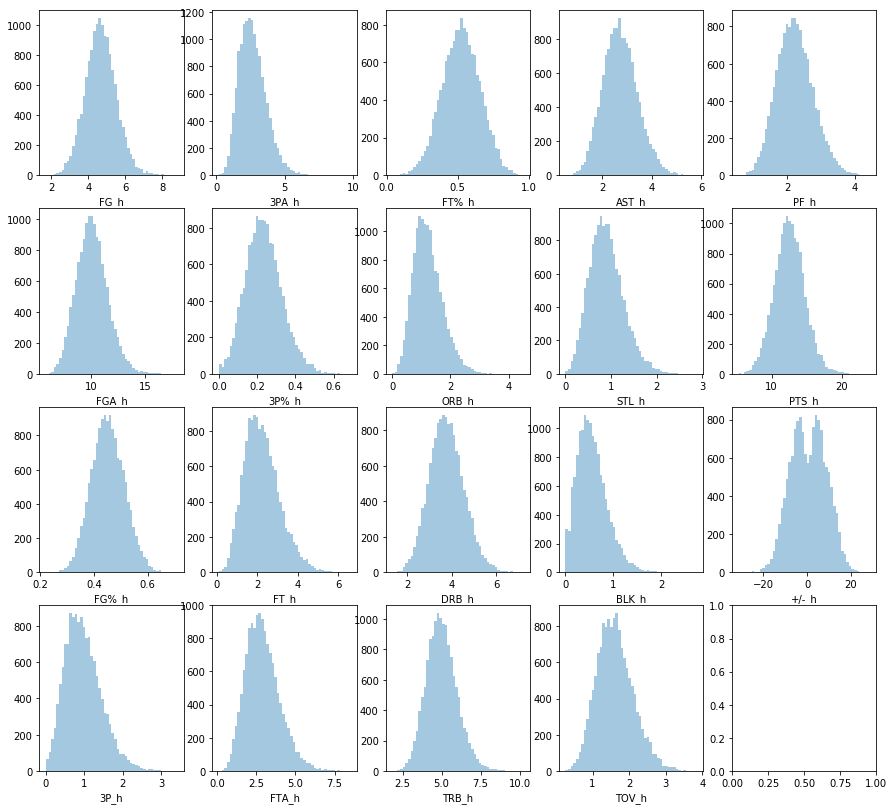

In [257]:
f, axes = plt.subplots(4, 5, figsize=(15, 14), sharex=False)
for i in range(19):
    sns.distplot(home_basic_df.iloc[:, i], kde = False, ax = axes[i%4, math.floor(i/4)])

#### Home Team Advanced Statistics

In [232]:
home_advanced_df = final_df_t1.iloc[:, 24:38]
home_advanced_df.head(3)

,TS%_h,eFG%_h,3PAr_h,FTr_h,ORB%_h,DRB%_h,TRB%_h,AST%_h,STL%_h,BLK%_h,TOV%_h,USG%_h,ORtg_h,DRtg_h
0,0.504170,0.406796,0.133864,0.413858,6.945368,17.022208,12.038257,14.562708,1.704708,2.582854,15.920604,19.993611,107.595486,91.194236
1,0.478694,0.437662,0.201196,0.292474,7.170597,12.992132,9.697289,15.369881,1.412730,1.033296,11.661208,19.979019,105.072956,114.875283
2,0.547741,0.473533,0.264221,0.578286,5.969631,12.923583,9.988340,13.078913,2.218452,1.521571,13.545117,20.007358,108.911515,100.197661


In [234]:
len(home_advanced_df.columns)

14

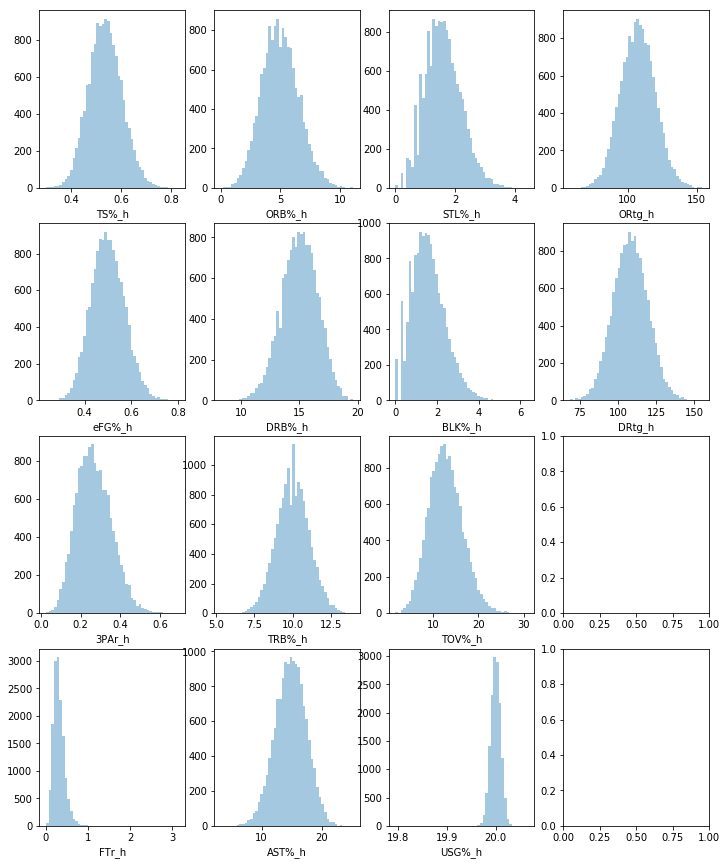

In [263]:
f, axes = plt.subplots(4, 4, figsize=(12, 15), sharex=False)
for i in range(14):
    sns.distplot(home_advanced_df.iloc[:, i], kde = False, ax = axes[i%4, math.floor(i/4)])

#### Away Team Basic Statistics

In [240]:
away_basic_df = final_df_t1.iloc[:, 41:60]
away_basic_df.head(3)

,FG_a,FGA_a,FG%_a,3P_a,3PA_a,3P%_a,FT_a,FTA_a,FT%_a,ORB_a,DRB_a,TRB_a,AST_a,STL_a,BLK_a,TOV_a,PF_a,PTS_a,+/-_a
0,4.926042,10.376667,0.451923,0.755486,2.847222,0.140722,3.325694,4.605208,0.523856,1.624097,4.692361,6.316458,2.622014,1.161042,0.740417,2.332500,3.536875,13.933264,1.150417
1,4.833970,10.417402,0.456217,1.025762,2.267690,0.296898,1.767516,2.892646,0.519309,1.591278,3.366988,4.958267,2.763766,0.321922,1.019651,2.314909,1.915909,12.461218,-6.807583
2,4.592639,10.081111,0.433798,0.825347,2.023125,0.196832,1.258889,1.965903,0.559826,0.618333,4.386042,5.004375,2.194792,0.531458,0.362431,2.421667,2.730625,11.269514,-7.182708


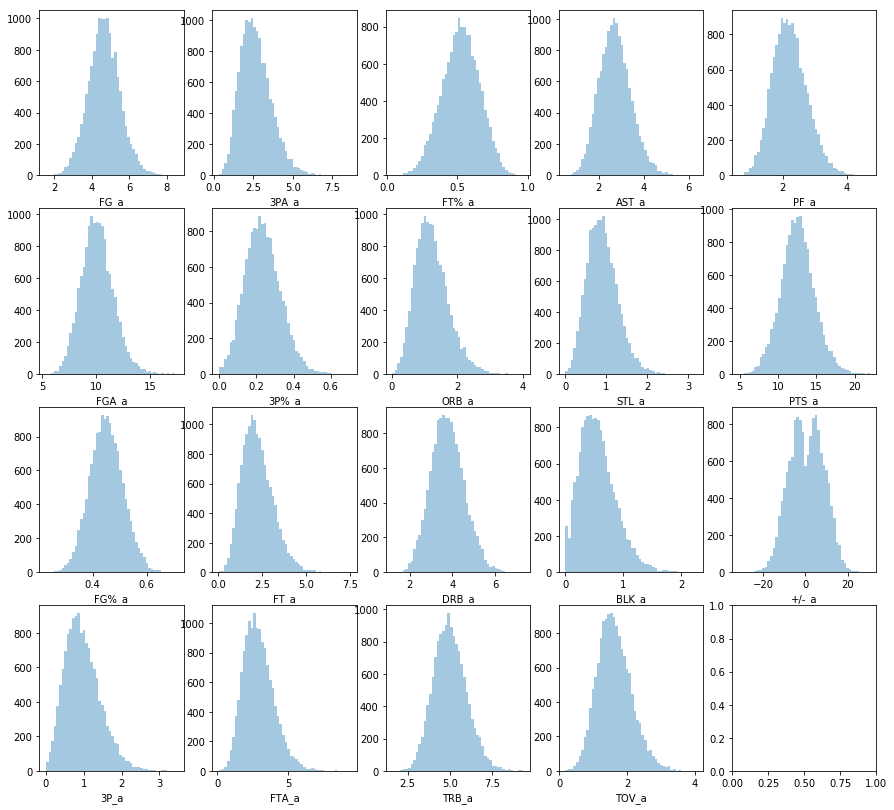

In [248]:
f, axes = plt.subplots(4, 5, figsize=(15, 14), sharex=False)
for i in range(19):
    sns.distplot(away_basic_df.iloc[:, i], kde = False, ax = axes[i%4, math.floor(i/4)])

#### Away Team Advanced Statistics

In [250]:
away_advanced_df = final_df_t1.iloc[:, 60:74]
away_advanced_df.head(3)

,TS%_a,eFG%_a,3PAr_a,FTr_a,ORB%_a,DRB%_a,TRB%_a,AST%_a,STL%_a,BLK%_a,TOV%_a,USG%_a,ORtg_a,DRtg_a
0,0.506680,0.492268,0.297409,0.373191,6.316465,15.416035,11.405576,16.642792,2.156701,1.464347,17.795868,19.987507,107.296944,99.171181
1,0.512285,0.495541,0.185664,0.316539,7.138956,15.105083,11.079654,14.945004,0.656447,2.602597,13.321290,19.998250,107.244358,116.952156
2,0.480903,0.468980,0.173404,0.275969,2.693604,14.892375,9.528479,10.501583,0.895111,1.309208,16.761042,19.995188,85.679444,101.400833


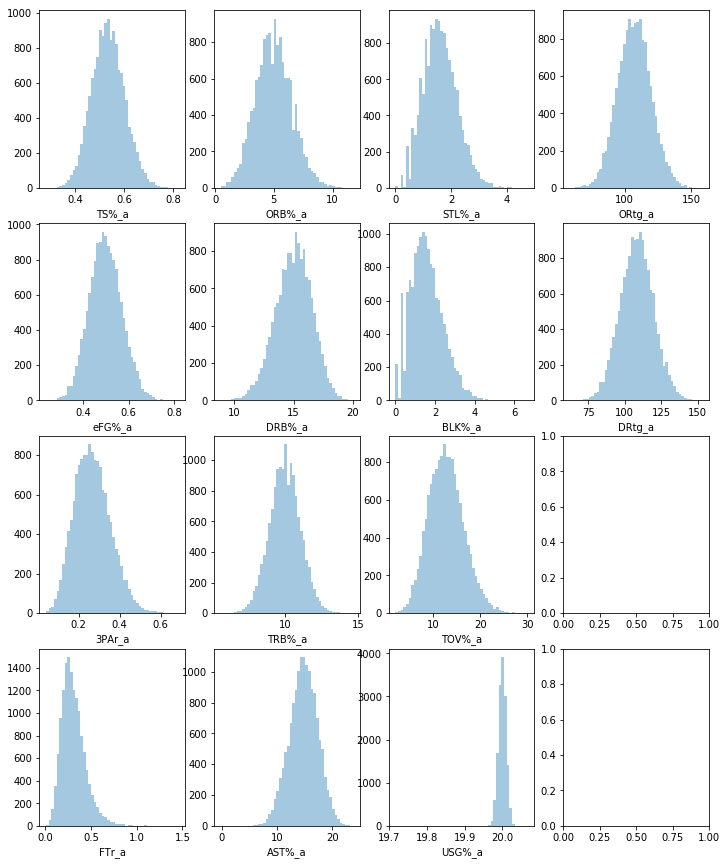

In [255]:
f, axes = plt.subplots(4, 4, figsize=(12, 15), sharex=False)
for i in range(14):
    sns.distplot(away_advanced_df.iloc[:, i], kde = False, ax = axes[i%4, math.floor(i/4)])

### EDA Part 2: Linear Correlation with the Target

### Feature Selestion by Decision Tree

Besides fitting all the features into the model, I will also do feature selection based on the importance from a decision tree. We decided to trust the model instead of choosing the feature by ourselves or by linear correlation.

### Box-cox Transformation

Conducting log transform may help to normalize a skewed distribution and to get a more robust result.

### Scale

I will scale my continuous features between 0 and 1. This will improve the computation of the models which count the distance among data points. Also, in a linear model, the feature with a larger value tends to be more important.

### Model Pipeline

- Cross Validation

    1. K Fold CV

    2. Grid Search or Random Search for Hyperparameter


- Model

    1. Logistic Regression (Our Baseline model)
    
    2. Ridge and Lasso Logistic Regression

    3. Random Forest (Bagging)

    4. KNN

    5. XGBoost (Boosting)

    6. SVM


- Metrics

    1. ROC

    2. Accuracy

    3. Recall Rate

    4. Precision